<a href="https://colab.research.google.com/github/musicjae/NLP/blob/master/Word2Vec/Word2Vec_studying.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

for fn in uploaded.keys(): # 업로드된 파일 정보 출력
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving w5.png to w5.png
User uploaded file "w5.png" with length 47828 bytes


In [2]:
from IPython.display import Image

# 1. Word2Vec 소개  


Mikolov와 그의 동료가 2013 년에 'Efficient Estimation of Word Representation in Vector Space'에서 제안한 2 가지 모델이 소위 Word2Vec의 시초라고 여겨지는 것 같다. 이번 글에서 나는 이 논문에서 제안된 2 가지 모델에 대해 소개하고 이것이 우리가 앞에서 알아보았던 NNLM (NPLM) 보다 더 좋은 성능을 제공한다는 것을 보인다.

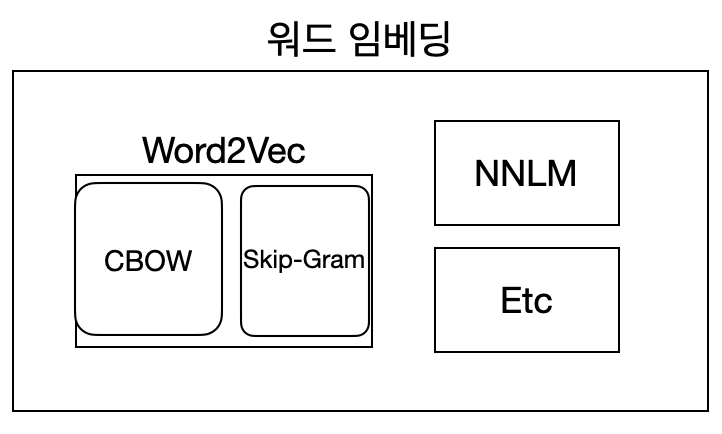

In [7]:
Image('w1.png',width=500)

## 1.1 NNLM vs Word2Vec  
  
앞에서 알아보았던 [NNLM](https://colab.research.google.com/drive/1ajh6ZbaxAUw91dqUw-eFCUU_7o_Bj653)은 이전 단어 시퀀스로부터 다음 단어를 예측하는 역할만 수행했다. 하지만 Word2Vec를 이용하면 그것보다 더 많은 역할을 수행할 수 있으며, 공학적인 이점도 얻을 수 있다:  
  
- (1) 한 문장 내의 어떤 자리에 있던 간에 그 단어(center word)를 다른 주변 단어 context words를 통해 예측할 수 있기 때문에 더 확장적인 역할을 수행한다.   
  
- (2) 이 기술은 단어들 간의 여러 측면의 유사성 -- 가령, 구문론적 유사성, 의미론적 유사성 등 -- 을 찾게 해준다.   
  
- (3) 대개의 경우에, Word2Vec 기술은 연산 복잡도 측면에 있어서 NNLM 보다 더 효율적이다.

## 1.2 두 종류의 Word2Vec의 메커니즘  
  
앞서 말했듯이, word2vec은 CBOW와 Skip-Gram 으로 구성된다. 이들은 다음 같은 절차를 통해 목적을 달성한다:

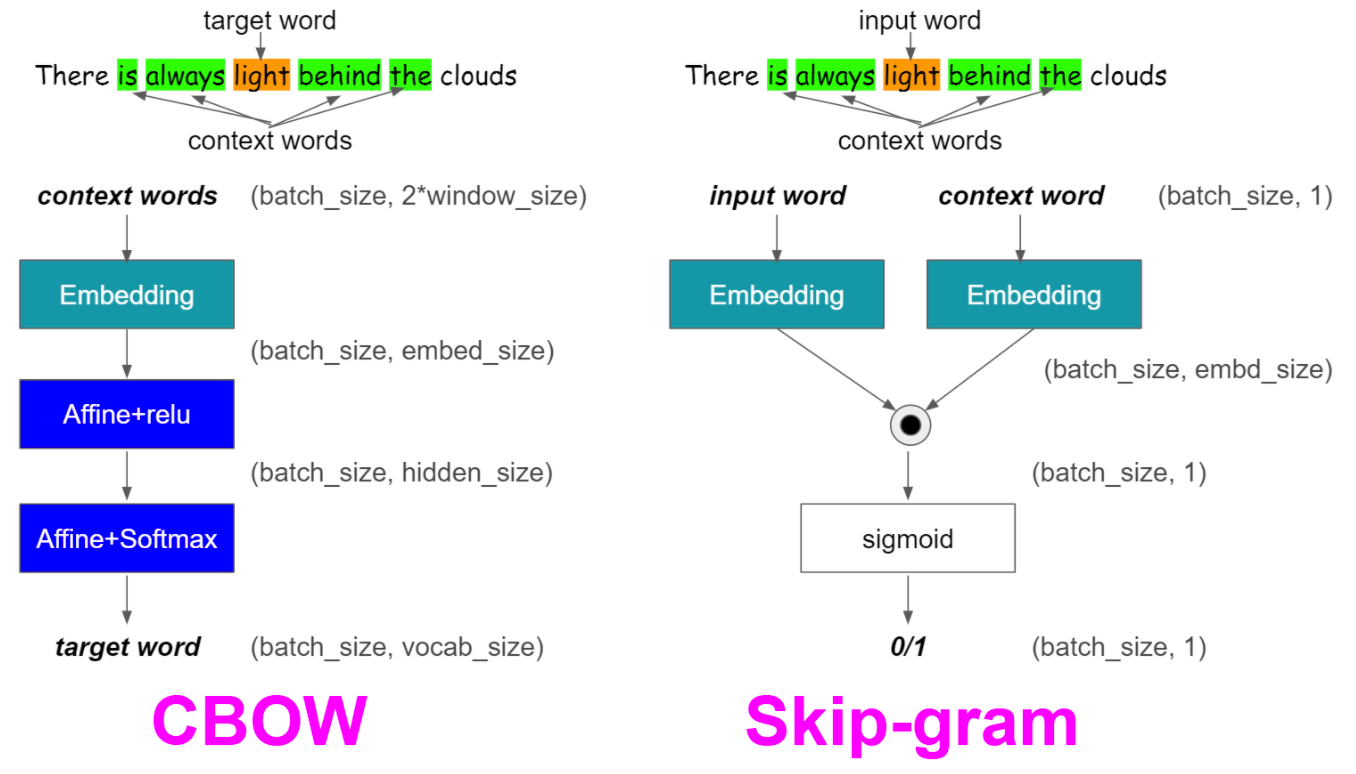

In [5]:
Image('w4.png',width=800)

#2. CBOW  
  
CBOW는 sequential 하지 않고, 확률적 방법을 채택하지 않기 때문에 언어 모델과 다르다.

### 2.1 파이토치에서 분산 표현을 사용하여 임베딩하는 방법

In [4]:
# see http://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [5]:
w2i = {'hello' : 0, 'world' : 1}
embed = nn.Embedding(2,5)
lookup_tensor = torch.tensor([w2i["hello"]], dtype=torch.long)
print("[1] lookup_tensor: ",lookup_tensor)
hello_embed = embed(lookup_tensor)
print('\n[2] hello_embed: ',hello_embed)
input

[1] lookup_tensor:  tensor([0])

[2] hello_embed:  tensor([[ 0.6614,  0.2669,  0.0617,  0.6213, -0.4519]],
       grad_fn=<EmbeddingBackward>)


<bound method Kernel.raw_input of <google.colab._kernel.Kernel object at 0x7f847ac5b2b0>>

## 2.2 CBOW

In [6]:
window = 2 # 왼쪽 오른쪽으로 2 개씩 context words를 조사  
EMBEDDING_DIM = 100

raw_text = """I said. Are you ignorant that for many years Agathon has not resided at Athens; and not three have elapsed since I became acquainted with Socrates, and have made it my daily business to know all that he says and does. There was a time when I was running about the world, fancying myself to be well employed, but I was really a most wretched thing, no better than you are now. I thought that I ought to do anything rather than be a philosopher.

Well, he said, jesting apart, tell me when the meeting occurred.
In our boyhood, I replied, when Agathon won the prize with his first tragedy, on the day after that on which he and his chorus offered the sacrifice of victory.

Then it must have been a long while ago, he said; and who told you-did Socrates?

No indeed, I replied, but the same person who told Phoenix;-he was a little fellow, who never wore any shoes Aristodemus, of the deme of Cydathenaeum. He had been at Agathon's feast; and I think that in those days there was no one who was a more devoted admirer of Socrates. Moreover, I have asked Socrates about the truth of some parts of his narrative, and he confirmed them. Then, said Glaucon, let us have the tale over again; is not the road to Athens just made for conversation? And so we walked, and talked of the discourses on love; and therefore, as I said at first, I am not ill-prepared to comply with your request, and will have another rehearsal of them if you like. For to speak or to hear others speak of philosophy always gives me the greatest pleasure, to say nothing of the profit. But when I hear another strain, especially that of you rich men and traders, such conversation displeases me; and I pity you who are my companions, because you think that you are doing something when in reality you are doing nothing. And I dare say that you pity me in return, whom you regard as an unhappy creature, and very probably you are right. But I certainly know of you what you only think of me-there is the difference.

Companion. I see, Apollodorus, that you are just the same-always speaking evil of yourself, and of others; and I do believe that you pity all mankind, with the exception of Socrates, yourself first of all, true in this to your old name, which, however deserved I know how you acquired, of Apollodorus the madman; for you are always raging against yourself and everybody but Socrates.""".split()
# http://classics.mit.edu/Plato/symposium.html

vocab=set(raw_text)
vocab_size = len(vocab)

print("vocab_size:  ",vocab_size)

vocab_size:   245


### context words, target words 분류하기

In [7]:
w2i = { word:i for i,word in enumerate(vocab)}
data=[]
for i in range(2, len(raw_text)-2): # 중심 단어만을 조사하기 때문에 앞뒤에서 각각 2 개 씩은 빼고 loop를 수행해준다.
    
    context = [raw_text[i-2],raw_text[i-1],raw_text[i+1],raw_text[i+2]] # 주변 단어
    target = raw_text[i] # 중심 단어
    data.append((context, target)) # 각 데이터마다 주변단어 + 중심단어를 묶어주기
print(data[:5])

[(['I', 'said.', 'you', 'ignorant'], 'Are'), (['said.', 'Are', 'ignorant', 'that'], 'you'), (['Are', 'you', 'that', 'for'], 'ignorant'), (['you', 'ignorant', 'for', 'many'], 'that'), (['ignorant', 'that', 'many', 'years'], 'for')]


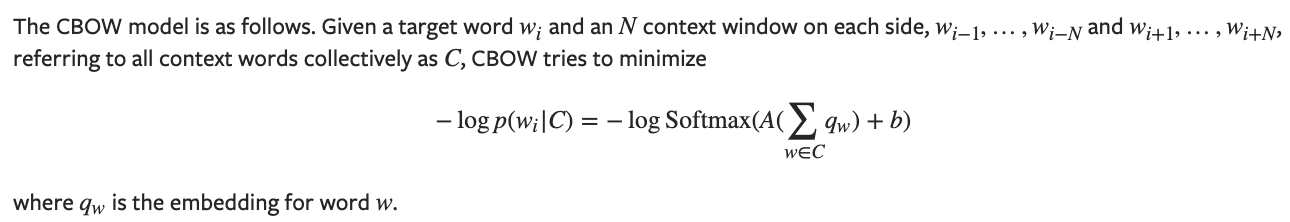

In [26]:
Image('w5.png',width=600)

### CBOW 모델 만들기

epoch:  0 cost:  5.551216125488281
epoch:  5 cost:  4.7450761795043945
epoch:  10 cost:  3.9508743286132812
epoch:  15 cost:  3.1473171710968018
epoch:  20 cost:  2.3475501537323
epoch:  25 cost:  1.5941722393035889
epoch:  30 cost:  0.9997901320457458
epoch:  35 cost:  0.6180443167686462
epoch:  40 cost:  0.4028928279876709
epoch:  45 cost:  0.2822706997394562


 Raw text: I said. Are you ignorant that for many years Agathon has not resided at Athens; and not three have elapsed since I became acquainted with Socrates, and have made it my daily business to know all that he says and does. There was a time when I was running about the world, fancying myself to be well employed, but I was really a most wretched thing, no better than you are now. I thought that I ought to do anything rather than be a philosopher. Well, he said, jesting apart, tell me when the meeting occurred. In our boyhood, I replied, when Agathon won the prize with his first tragedy, on the day after that on which he an

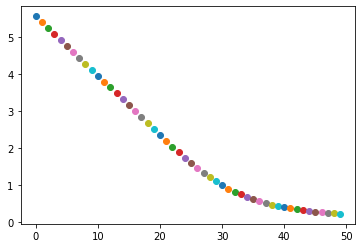

In [15]:
import matplotlib.pylab as plt
%matplotlib inline

def make_context_vector(context, w2i):
    idxs =[w2i[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

class CBOW(nn.Module):

    def __init__(self, vocab_size, embed_dim):
        super(CBOW,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim) # (배치 사이즈, 임베딩 사이즈)
        self.linear1 = nn.Linear(embed_dim, 128)
        self.relu = nn.ReLU()

        self.linear2 = nn.Linear(128, vocab_size)
        self.logsoftmax = nn.LogSoftmax(dim = -1) # class에서 Logsoftmax 사용 --> loss함수로 NLLLoss 사용

    def forward(self, inputs):

        embeds = sum(self.embedding(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.logsoftmax(out)

        return out

    def get_word_embedding(self, word):

        word = torch.tensor([w2i[word]])
        return self.embedding(word).view(1,-1)


if __name__ == "__main__":

    model = CBOW(vocab_size, EMBEDDING_DIM)
    loss_fn = nn.NLLLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    #w2i, i2W

    w2i = {word:i for i, word in enumerate(vocab)}
    i2w = {i:word for i,word in enumerate(vocab)}

    # 트레이닝

    for epoch in range(50):

        total_loss = 0

        for context, target in data: # ([contexts, target])의 집합이 있는 data
            context_vector = make_context_vector(context, w2i)
            
            log_probs = model(context_vector)

            total_loss = loss_fn(log_probs, torch.tensor([w2i[target]]))
        
        if (epoch)%5 ==0:
                print('epoch: ', epoch, 'cost: ', total_loss.item()) 
                
        # matplotlib

        plt.plot(epoch,total_loss.item(),marker='o')

        
        # 매 epoch 마다 최적화

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # 테스트

    context = ['but','the','person','who']
    context_vector = make_context_vector(context,w2i)
    testing_model = model(context_vector)

    # 결과 출력

    #Print result
    print('\n\n',f'Raw text: {" ".join(raw_text)}\n')
    print(f'Context: {context}\n')
    print(f'Prediction: {i2w[torch.argmax(testing_model[0]).item()]}\n\n')



# 3. Skip - Gram  


## References  
[1] https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html#word-embeddings-in-pytorch  
[2] Mikolov, Tomas, et al. "Efficient estimation of word representations in vector space." arXiv preprint arXiv:1301.3781 (2013)  
[3]https://github.com/musicjae/NLP/blob/master/Word2Vec/Word2Vec(2)%20Mikolov.%20et%20al%2C%20%E2%80%98Efficient%20Estimation%20of%20Word%20Representations%20in%20Vector%20Space%E2%80%99%20(2013)%20%20.pdf 위 [2] 논문에 대한 국역 요약글을 이곳에 정리해두었다.  

[4] https://wikidocs.net/22660  
[5] https://github.com/FraLotito/pytorch-continuous-bag-of-words/blob/master/cbow.py